## Setup

In [234]:
import shap

import numpy as np
import xarray as xr
import pandas as pd

from sklearn import feature_selection, svm, preprocessing, model_selection, ensemble
from sklearn import neighbors
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('paper')
import plotly.express as px
from tqdm import tqdm

shap.initjs()

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-18T22:12:02.604975+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

shap      : 0.40.0
numpy     : 1.21.5
matplotlib: 3.5.1
json      : 2.0.9
seaborn   : 0.11.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
plotly    : 5.5.0
sklearn   : 1.0.2
pandas    : 1.4.0
ipykernel : 6.9.0
xarray    : 0.21.1
debugpy   : 1.5.1



In [235]:
# parameters

TRIU_K = 0
DATASET_NAME = 'dosenbach2007_tangent'

## Data

In [236]:
atlases = ['dosenbach2007', 'difumo_64_2',]# 'difumo_128_2',]# 'difumo_1024_2']

connectivity_measures = ['tangent', 'precision', 'correlation',
                         'covariance', 'partial_correlation']

DATASETS = dict()

for atlas in atlases:
  for connectivity in connectivity_measures:
    _conn_key = f'{connectivity}_connectivity'
    ds = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')
    _conn = ds[_conn_key]
    _conn.coords['group'] = ds.group
    _conn['inverse_efficiency_score_ms'] = ds['inverse_efficiency_score_ms']
    DATASETS[f'{atlas}_{connectivity}'] = _conn
    
    if 'difumo_names' in ds.coords:
      _conn.coords['region'] = ds.coords['difumo_names'].values


In [237]:
dataset = DATASETS[DATASET_NAME]

behavioral_scores = ds['inverse_efficiency_score_ms'].values

# remove subjects with missing behavioral data or duplicate scanning sessions
# subject_labels = xr.concat([dataset['subject'], dataset['subject'] + 'NEW'], dim='subject')
# invalid_subjects = subject_labels.to_series().duplicated(keep='first')[34:]
# invalid_subjects = invalid_subjects | np.isnan(behavioral_scores)
invalid_subjects = np.isnan(behavioral_scores)

In [238]:
regions = dataset.coords['region'].values

feature_names = pd.DataFrame(
  np.empty((len(regions), len(regions))),
  index=regions, columns=regions)

feature_names = feature_names.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
feature_names = feature_names.values[np.triu_indices_from(feature_names.values, k=TRIU_K)]

# X
X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=TRIU_K)]
              for subj_conn in dataset.values])

X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

# y
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(ds['group'])

# remove subjects with missing behavioral data
X = X[~invalid_subjects]
y = y[~invalid_subjects]



## Model

In [239]:

model = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold(.01)),
    ('model', svm.SVC(kernel='rbf', C=1, probability=True)),
], verbose=False)

# TODO hyper-parameter tuning

train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,
)

model.fit(X[train], y[train])
test_score = model_selection.cross_val_score(
    model, X, y, n_jobs=-1, scoring='roc_auc',
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=100),
)

print(f'mean(CV-AUC): {test_score.mean():.2f}')

perm_score, _, pvalue = model_selection.permutation_test_score(
    model, X, y,
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10),
    n_jobs=-1,
    n_permutations=100,
    # cv=5,
    scoring='roc_auc')

print(f'Permutation test AUC: {perm_score:.2f} (p-value={pvalue:.3f})')

mean(CV-AUC): 0.69
Permutation test AUC: 0.70 (p-value=0.059)


In [240]:
# fit the model
model.fit(X, y)
model.score(X, y)

1.0

In [250]:
cv_shap_values = []
cv_test_indices = []

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

for train, test in cv.split(X, y):

    # train the model
    model.fit(X[train], y[train])
    
    # # fit explainer
    explainer = shap.Explainer(
        model.predict, X[train],
        feature_names=feature_names,
        algorithm='permutation',
        output_names=dataset['group'].values[train]
    )
    
    # evaluate explainer
    shap_values = explainer(X[test], max_evals= 100 * X.shape[1] + 1)

    cv_shap_values.append(shap_values)
    cv_test_indices.append(test)


Permutation explainer: 8it [03:25, 29.29s/it]                       
Permutation explainer: 8it [03:45, 32.20s/it]                       
Permutation explainer: 7it [03:28, 34.83s/it]                       
Permutation explainer: 7it [02:58, 29.69s/it]                       
Permutation explainer: 7it [02:52, 28.76s/it]                       
Permutation explainer: 8it [03:14, 27.85s/it]                       
Permutation explainer: 8it [03:02, 26.03s/it]                       
Permutation explainer: 7it [02:44, 27.46s/it]                       
Permutation explainer: 7it [02:44, 27.49s/it]                       
Permutation explainer: 7it [02:44, 27.37s/it]                       
Permutation explainer: 8it [03:05, 26.50s/it]                       
Permutation explainer: 8it [02:57, 25.29s/it]                       
Permutation explainer: 7it [02:53, 28.96s/it]                       
Permutation explainer: 7it [03:01, 30.29s/it]                       
Permutation explainer: 7it [09:39,

In [286]:
cv_shap_values_merged = np.concatenate([v.values for v in cv_shap_values], axis=0)
X_test = pd.DataFrame(X[np.concatenate([v for v in cv_test_indices], axis=0)], columns=feature_names)

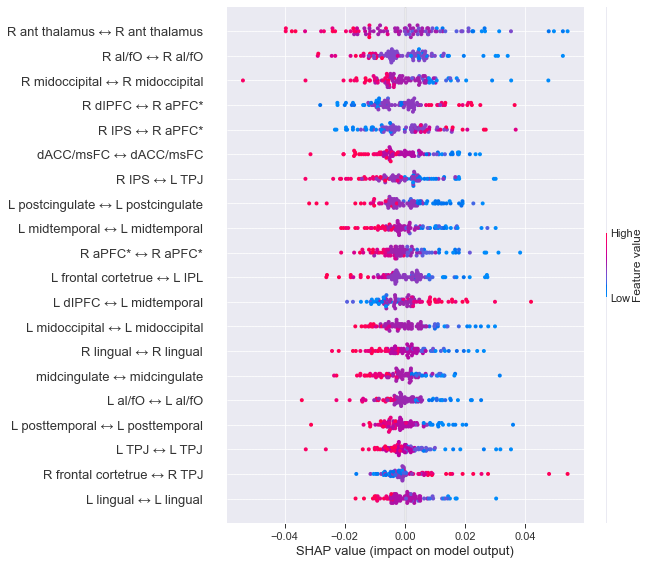

In [287]:
shap.summary_plot(cv_shap_values_merged, X_test)

In [ ]:
# shap.force_plot(explainer.expected_value, cv_shap_values_merged, X_test)

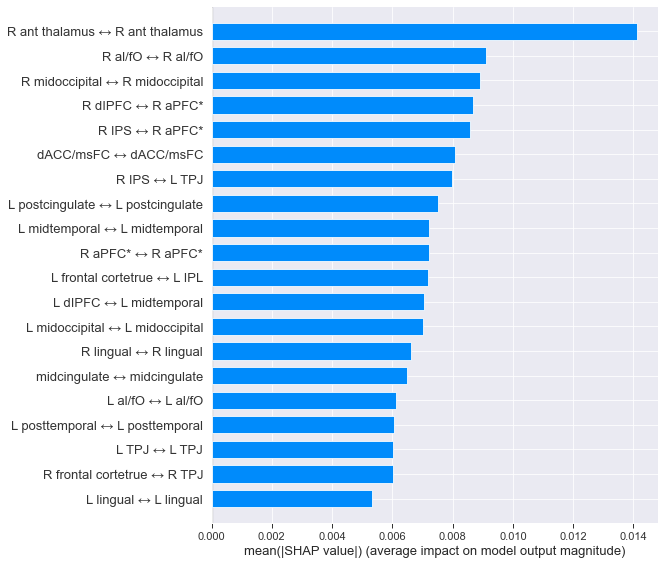

In [293]:
clustering = None
# clustering = shap.utils.hclust(X, y)

shap.summary_plot(cv_shap_values_merged, X_test, plot_type='bar')

(780,)

In [298]:
shap2d_size = len(dataset.coords['region'])

agg_shap_values = np.abs(cv_shap_values_merged).sum(axis=0)
# agg_shap_values = shap_values.abs.sum(0).values


shap2d_values = np.zeros((shap2d_size, shap2d_size))
shap2d_triu_indices = np.triu_indices(shap2d_size, k=TRIU_K)
shap2d_values[shap2d_triu_indices] = agg_shap_values
shap2d_values = shap2d_values + shap2d_values.T - np.diag(np.diag(shap2d_values))

shap2d = pd.DataFrame(shap2d_values,
                      index=dataset.coords['region'],
                      columns=dataset.coords['region'])


sorted_shap_indices = np.argsort(agg_shap_values)[::-1]
top_n = 10
triu_idx = sorted_shap_indices[:top_n]
row_idx = np.triu_indices(shap2d_size, k=TRIU_K)[0][triu_idx]
col_idx = np.triu_indices(shap2d_size, k=TRIU_K)[1][triu_idx]

# DEBUG make sure indices are mapped correctly
assert np.all(shap2d_values[row_idx,col_idx] == agg_shap_values[triu_idx])


print('Top contributing connectivities:')
for i, (row, col) in enumerate(zip(row_idx, col_idx)):
  # print(f'{shap2d.index[i]} - {shap2d.columns[j]}')
  print(f'{i+1}) ',
        dataset.coords['region'].values[row], '<->',
        dataset.coords['region'].values[col])


# run 1:
# Top contributing connectivities:
# 1)  R dIPFC <-> R aPFC*
# 2)  R lat cerebellum <-> L midoccipital
# 3)  R al/fO <-> R al/fO
# 4)  R ant thalamus <-> R ant thalamus
# 5)  dACC/msFC <-> dACC/msFC

# Top contributing connectivities:
# 1)  R ant thalamus <-> R ant thalamus
# 2)  R IPS <-> R aPFC*
# 3)  R dIPFC <-> R aPFC*
# 4)  L midoccipital <-> L midoccipital
# 5)  R al/fO <-> R al/fO

# Top contributing connectivities:
# 1)  R ant thalamus <-> R ant thalamus
# 2)  R frontal cortetrue <-> R TPJ
# 3)  R dIPFC <-> R aPFC*
# 4)  R frontal cortetrue <-> R IPL
# 5)  L midoccipital <-> L midoccipital
# 6)  R dIPFC <-> R midtemporal
# 7)  R midoccipital <-> R midoccipital
# 8)  L dIPFC <-> L midtemporal
# 9)  R IPS <-> L TPJ
# 10)  midcingulate <-> midcingulate

Top contributing connectivities:
1)  R ant thalamus <-> R ant thalamus
2)  R al/fO <-> R al/fO
3)  R midoccipital <-> R midoccipital
4)  R dIPFC <-> R aPFC*
5)  R IPS <-> R aPFC*
6)  dACC/msFC <-> dACC/msFC
7)  R IPS <-> L TPJ
8)  L postcingulate <-> L postcingulate
9)  L midtemporal <-> L midtemporal
10)  R aPFC* <-> R aPFC*


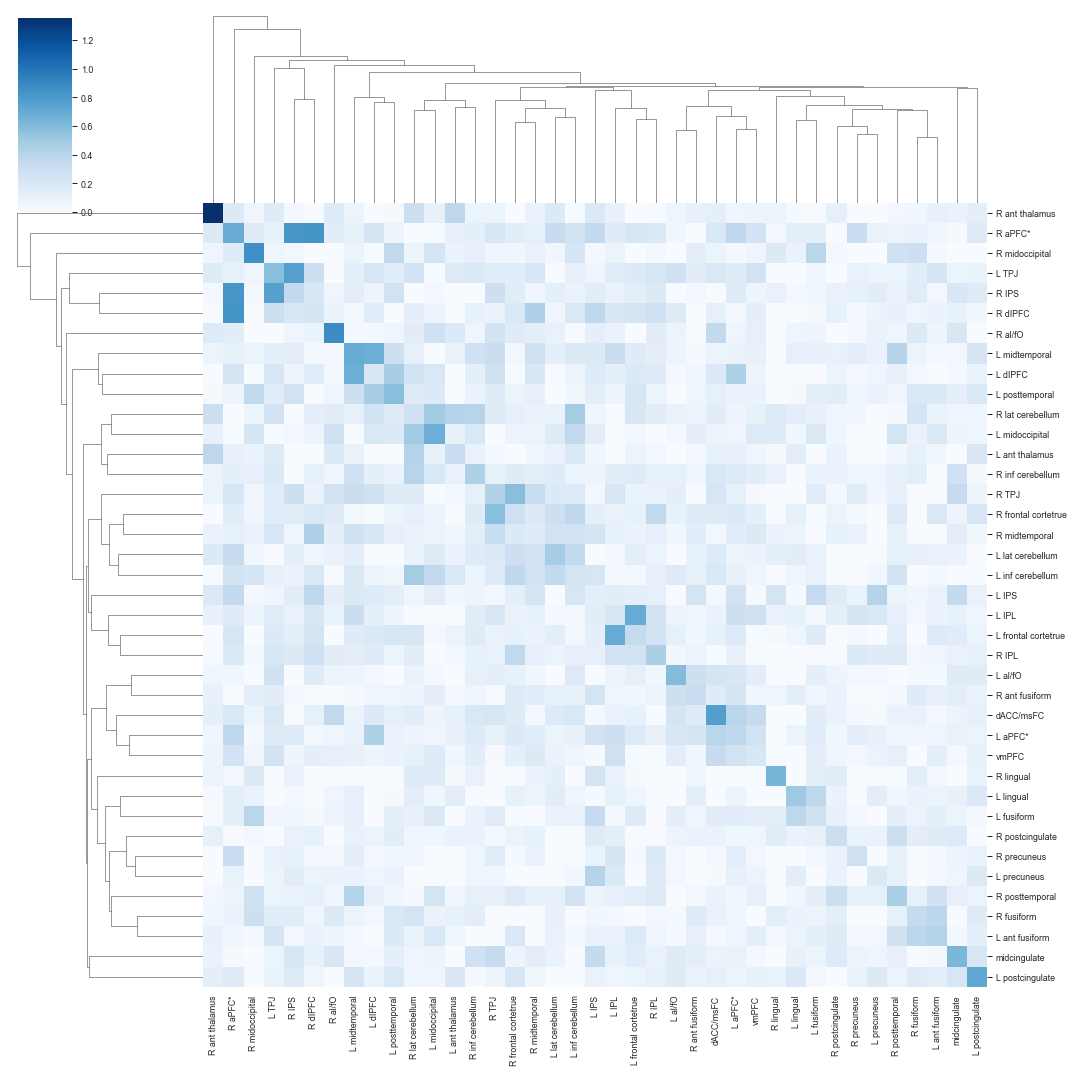

In [299]:
sns.clustermap(shap2d, figsize=(15,15), robust=False, cmap='Blues')
plt.show()

## interactive heatmap (but not clustered)
# fig = px.imshow(shap2d, aspect='auto', height=800)
# fig.show()